In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_score

In [0]:
pledge_dir = '/content/drive/My Drive/train_pledge.csv'
label_dir = '/content/drive/My Drive/train_label_add.csv'
pay_dir = '/content/drive/My Drive/train_payment.csv'
activity_dir = '/content/drive/My Drive/train_activity.csv'
combat_dir = '/content/drive/My Drive/train_combat.csv'
trade_dir = '/content/drive/My Drive/train_trade.csv'

In [0]:
train_activity = pd.read_csv(activity_dir)
train_activity = train_activity[train_activity.server != 'bs']
train_activity = train_activity[train_activity.playtime != 0]
train_combat = pd.read_csv(combat_dir)
train_trade = pd.read_csv(trade_dir)
train_label = pd.read_csv(label_dir)
del train_label['Unnamed: 0']
train_payment = pd.read_csv(pay_dir)

In [0]:
merge_all_flatten = pd.read_csv('/content/drive/My Drive/merge_all_flatten.csv')

In [6]:
merge_all_flatten.shape

(40000, 401)

In [0]:
merge_all = pd.merge(merge_all_flatten, train_label, on = 'acc_id')

In [0]:
# merge_all.rename(columns = {'amount_spent_x' : 'amount_apent'}, inplace = True)
merge_all.rename(columns = {'amount_spent_x' : 'amount_spent'}, inplace = True)

In [0]:
merge_all_sub = merge_all.copy()

# for i in cut_df[cut_df.secession == 0]['acc_id'].values:
#     merge_all_sub = merge_all_sub[merge_all_sub['acc_id'] != i]

In [0]:
time_freq = pd.DataFrame(merge_all_sub['survival_time'].value_counts()).reset_index()

In [0]:
time_freq.columns = ['survival_time', 'freq']

In [0]:
dic = {}
for i in range(1,13):
    dic[i] = 1
    
for j in range(13,30):
    dic[j] = 2
    
for z in range(30,64):
    dic[z] = 3

dic[64] = 4

time_freq['range'] = time_freq['survival_time'].map(dic)

In [0]:
merge_all_sub['survival_term'] = merge_all_sub['survival_time'].map(dic)

In [14]:
merge_all_sub.shape

(40000, 406)

In [0]:
survival_term1 = merge_all_sub[(merge_all_sub.survival_term == 1)]
survival_term2 = merge_all_sub[(merge_all_sub.survival_term == 2)]
survival_term3 = merge_all_sub[(merge_all_sub.survival_term == 3)]

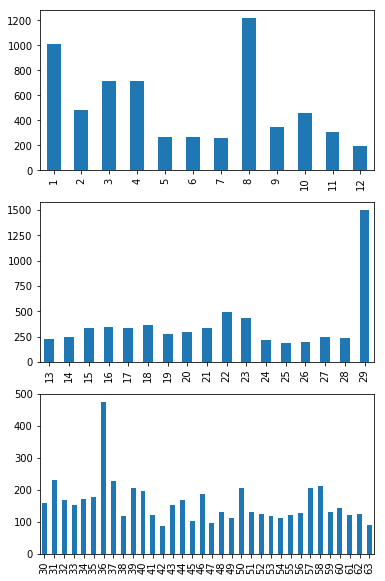

In [16]:
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(3,1,1)
ax1 = survival_term1.survival_time.value_counts().sort_index().plot(kind = 'bar')
# ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(3,1,2)
ax2 = survival_term2.survival_time.value_counts().sort_index().plot(kind = 'bar')
# ax2.set_ylim([0,8200])
ax2 = fig.add_subplot(3,1,3)
ax2 = survival_term3.survival_time.value_counts().sort_index().plot(kind = 'bar')

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(survival_term2.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 survival_term2.survival_time,
                                 test_size = 0.3, random_state=42)


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4414, 401), (4414,), (1893, 401), (1893,))

In [23]:
import xgboost as xgb

np.random.seed(42)



xg_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
#               scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')



xg_clf.fit(X_train.drop('acc_id', axis=1),y_train, verbose = 0)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='multi:softprob', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
              verbosity=1)

In [0]:
import pickle
with open('/content/drive/My Drive/cluster2.pkl', 'wb') as f:
    pickle.dump(xg_clf, f)

In [24]:
from sklearn.metrics import f1_score
y_pred = xg_clf.predict(X_test.drop('acc_id', axis=1))
# = predictions = [round(value) for value in y_pred]

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

(0.3539355520338088, 0.3391736300724034)

(0, 420)

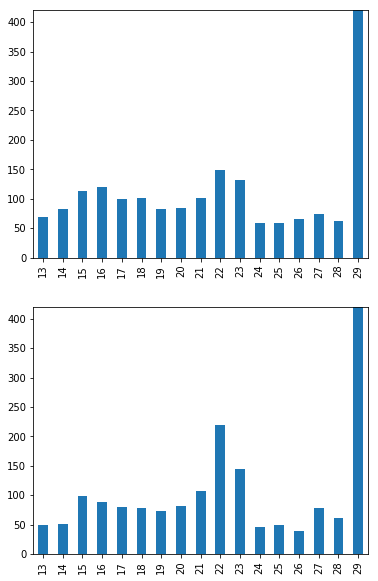

In [25]:
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,420])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,420])

# 접어 아래는

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_df.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 merge_df.survival_term,
                                 test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape,  X_test.shape, y_train.shape, y_test.shape

((28000, 240), (12000, 240), (28000,), (12000,))

In [0]:
import xgboost as xgb

np.random.seed(42)


xg_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
#               scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 6,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')


# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# eval_set = eval_set,

xg_clf.fit(X_train.drop('acc_id', axis=1),y_train, sample_weight = w1)


In [20]:
y_pred = xg_clf.predict(X_test.drop('acc_id', axis=1))
# = predictions = [round(value) for value in y_pred]

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

(0.6786666666666666, 0.6455674027963243)

0.7924141465914916
0.6004162330905307
0.3462986198243413
0.03995101790907699


(0, 8200)

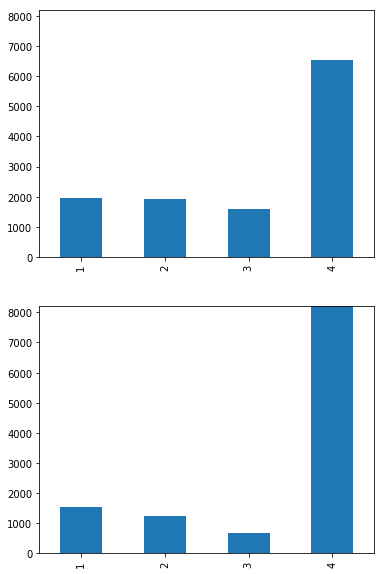

In [21]:
print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())
print(((y_pred == 2).sum()&(y_test==2).sum()) / (y_test==2).sum())
print(((y_pred == 3).sum()&(y_test==3).sum()) / (y_test==3).sum())
print(((y_pred == 4).sum()&(y_test==4).sum()) / (y_test==4).sum())

fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,8200])

In [11]:
# sample_weight에 입력 할 list 생성

# 기본 공식
# 낮은 % / 높은 % ( 둘이 합쳤을 떄 100% 기준 )

import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


# dic = get_class_weights(y_test)
dic = {1:1.8, 2:1.6, 3:0.4, 4:3.4}
w1 = np.array(y_test.map(dic))

dic

{1: 1.8, 2: 1.6, 3: 0.4, 4: 3.4}

# test set에 적용

In [0]:
test1_dir = '/content/drive/My Drive/merge_all_flatten_test1.csv'
test2_dir = '/content/drive/My Drive/merge_all_flatten_test2.csv'


In [0]:
test1 = pd.read_csv(test1_dir)
test2 = pd.read_csv(test2_dir)

In [0]:
import pickle
with open('/content/drive/My Drive/quad_clf.pkl', 'rb') as f:
    quad_clf = pickle.load(f)

In [0]:
import pickle
with open('/content/drive/My Drive/cluster1.pkl', 'rb') as f:
    cluster1 = pickle.load(f)

In [0]:
import pickle
with open('/content/drive/My Drive/cluster2.pkl', 'rb') as f:
    cluster2 = pickle.load(f)

In [0]:
import pickle
with open('/content/drive/My Drive/cluster3.pkl', 'rb') as f:
    cluster3 = pickle.load(f)

In [0]:
quad1 = quad_clf.predict(np.array(test1.drop('acc_id', axis=1)))
quad2 = quad_clf.predict(np.array(test2.drop('acc_id', axis=1)))

In [0]:
quad1_df = pd.DataFrame({'acc_id' : test1.acc_id, 'survival_term' : quad1})
quad2_df = pd.DataFrame({'acc_id' : test2.acc_id, 'survival_term' : quad2})

In [0]:
quad1_1 = quad1_df[quad1_df.survival_term == 1]
quad1_2 = quad1_df[quad1_df.survival_term == 2]
quad1_3 = quad1_df[quad1_df.survival_term == 3]
quad1_4 = quad1_df[quad1_df.survival_term == 4]

In [0]:
quad2_1 = quad2_df[quad2_df.survival_term == 1]
quad2_2 = quad2_df[quad2_df.survival_term == 2]
quad2_3 = quad2_df[quad2_df.survival_term == 3]
quad2_4 = quad2_df[quad2_df.survival_term == 4]

In [0]:
qquad1_1 = pd.merge(quad1_1, test1, on = 'acc_id', how = 'left').drop('survival_term', axis=1)
qquad1_2 = pd.merge(quad1_2,test1, on = 'acc_id', how = 'left').drop('survival_term', axis=1)
qquad1_3 = pd.merge(quad1_3,test1, on = 'acc_id', how = 'left').drop('survival_term', axis=1)
qquad1_4 = pd.merge(quad1_4,test1, on = 'acc_id', how = 'left').drop('survival_term', axis=1)

In [0]:
qquad2_1 = pd.merge(quad2_1,test2, on = 'acc_id', how = 'left').drop('survival_term', axis=1)
qquad2_2 = pd.merge(quad2_2,test2, on = 'acc_id', how = 'left').drop('survival_term', axis=1)
qquad2_3 = pd.merge(quad2_3,test2, on = 'acc_id', how = 'left').drop('survival_term', axis=1)
qquad2_4 = pd.merge(quad2_4,test2, on = 'acc_id', how = 'left').drop('survival_term', axis=1)

In [0]:
qquad1_1.rename(columns={'amount_spent':'amount_spent_x'}, inplace=True)

In [0]:
qquad1_2.rename(columns={'amount_spent_x':'amount_spent'}, inplace=True)
qquad1_3.rename(columns={'amount_spent':'amount_spent_x'}, inplace=True)
qquad2_1.rename(columns={'amount_spent':'amount_spent_x'}, inplace=True)
qquad2_2.rename(columns={'amount_spent':'amount_spent_x'}, inplace=True)
qquad2_3.rename(columns={'amount_spent':'amount_spent_x'}, inplace=True)

In [0]:
qquad2_2.rename(columns={'amount_spent_x':'amount_spent'}, inplace=True)

In [0]:
class1_1 = cluster1.predict(qquad1_1.drop('acc_id', axis=1))
class1_2 = cluster2.predict(qquad1_2.drop('acc_id', axis=1))
class1_3 = cluster3.predict(qquad1_3.drop('acc_id', axis=1))

In [0]:
class2_1 = cluster1.predict(qquad2_1.drop('acc_id', axis=1))
class2_2 = cluster2.predict(qquad2_2.drop('acc_id', axis=1))
class2_3 = cluster3.predict(qquad2_3.drop('acc_id', axis=1))

In [121]:
qquad1_4.shape[0]

6630

In [0]:
pre1_1 = pd.DataFrame({'acc_id':qquad1_1.acc_id, 'survival_time':class1_1})
pre1_2 = pd.DataFrame({'acc_id':qquad1_2.acc_id, 'survival_time':class1_2})
pre1_3 = pd.DataFrame({'acc_id':qquad1_3.acc_id, 'survival_time':class1_3})
pre1_4 = pd.DataFrame({'acc_id':qquad1_4.acc_id, 'survival_time':[64]*qquad1_4.shape[0]})

In [0]:
pre2_1 = pd.DataFrame({'acc_id':qquad2_1.acc_id, 'survival_time':class2_1})
pre2_2 = pd.DataFrame({'acc_id':qquad2_2.acc_id, 'survival_time':class2_2})
pre2_3 = pd.DataFrame({'acc_id':qquad2_3.acc_id, 'survival_time':class2_3})
pre2_4 = pd.DataFrame({'acc_id':qquad2_4.acc_id, 'survival_time':[64]*qquad2_4.shape[0]})

In [0]:
test1_predict = pd.concat([pre1_1,pre1_2,pre1_3,pre1_4], ignore_index = True)
test2_predict = pd.concat([pre2_1,pre2_2,pre2_3,pre2_4], ignore_index = True)

In [0]:
test1_predict.sort_values(by = 'acc_id', inplace = True)
test2_predict.sort_values(by = 'acc_id', inplace = True)

In [0]:
test1_predict.to_csv('/content/drive/My Drive/test1_predict.csv', index = False)
test2_predict.to_csv('/content/drive/My Drive/test2_predict.csv', index = False)

In [0]:
cluster1.predict()